# **EXOPLANETS CLASSIFICATION**

### Importing Files

In [2]:
# Importing and installing necessary modules
!pip install pyts
!pip install keras

from pyts.image import RecurrencePlot

import matplotlib.pyplot as plt
import sys
from numpy import genfromtxt
import numpy as np
np.set_printoptions(threshold=sys.maxsize)

from scipy import pi
from scipy import fftpack
from scipy.fft import fft, fftfreq, ifft
from scipy.spatial.distance import pdist, squareform

import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from pylab import rcParams

from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.utils.data import get_pkg_data_filename
from astropy.table import Table, QTable
import astropy.io.fits as fits

import sklearn as sk
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import precision_score, recall_score,roc_curve, auc, f1_score, roc_auc_score,confusion_matrix, accuracy_score, classification_report
from sklearn.svm import SVC

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow import keras

from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from csv import writer 
import csv
from csv import reader

import cv2
from contextlib import redirect_stdout
import seaborn as sns

     |████████████████████████████████| 2.5 MB 4.1 MB/s 


### Data used for Analysis

The Data used for the analysis is downloaded from <a href="https://archive.stsci.edu/kepler/data_search/search.php">this</a> website. Positive data are downloaded by selecting Condition flag as `ExoPlanet Host Star` and Negative examples are downloaded by setting Condition flag as `Flase Positive`.  

The data downloaded is in the form of links as shown in `Exo_link` and `NoExo_link` text files. Each link represent a light curve time series from a single celestial body. This can later be used to classifiy whether it is a Exo Planet or Non Exo Planet body. 

### Data Preparation 

Below cell read the text files containing links and saves all the links in a list format to access later. Total number of links for Positive datapoints downloaded are 34744. Whereas number of links for Negative datapoints are 50002. 

In [3]:
# Reading the data from the txt files and storing the data in variables: Exo_content_list and No_Exo_content_list. 
# The data in the txt files contains the links of dataset. These links are stored in variable named: 
# Exo_content_list and No_Exo_content_list in the form of list.

reader1 = open(r"/EXO/Exo_link.txt", "r")
reader2 = open(r"/NO_EXO/NoExo_link.txt", "r")
Exo_content_list = reader1.read().split("\n")
No_Exo_content_list = reader2.read().split("\n")
reader1.close()
reader2.close()

print("Total number of links for Exoplanets is: ",len(Exo_content_list))
print("Total number of links for Non Exoplanets is: ",len(No_Exo_content_list))

Total number of links for Exoplanets is:  34744
Total number of links for Non Exoplanets is:  50002


In the below cell Constants are Declared

In [4]:
# Declaring constants to be used in the code
# Training data is 80% of Total data set whereas Testing data is reamining 20%

TotalData = 8000  # Positive + Negative dataset
SPLIT_RATIO = 0.8 # ratio of training data/total data
TRAIN_EXAMPLES = int(SPLIT_RATIO * TotalData)
TEST_EXAMPLES = int(np.round((1-SPLIT_RATIO),1) * TotalData)
COLUMNS_FOR_TRAINING = 20000
DATA_TO_COPY2CSV = 8000
HEIGHT = 100
WIDTH = 100
IMAGE_SHAPE = (HEIGHT,WIDTH,1) 

After the links are saved to a list, the data from those lists needs to downloaded for further analysis. Below cell reads data links from text files Exo_link.txt and NoExo_link.txt and saves the actual Exo Planets Light curve data in a data frame. I have commented out below cell, as I am providing the already downloaded light curve data in the files namely `POS_TimeSeries.csv` containing positive data and `NEG_TimeSeries.csv` which contains negative data.    

In [5]:
# # The data is read from the links and stored in variable called Data_Exo and Data_No_Exo
# # This data is in FITS(Flexible Image Transport System) format and can be accessed using astropy lib in python. 

# # Saving data from the links to CSV file in time series
# # Total data contains number of data sets used for testing and training. 
# # Enter split ratio for training data

# POS = pd.DataFrame() 

# for i in range(DATA_TO_COPY2CSV):
#      Data_Exo = fits.open(Exo_content_list[i])
#      flux = Data_Exo[1].data['PDCSAP_FLUX'].byteswap().newbyteorder()
#      mean = np.nanmean(flux)
#      inds = np.where(np.isnan(flux))
#      flux[inds] = mean
#      POS = POS.append(pd.DataFrame(flux.reshape(1,flux.shape[0]), dtype='float32'))
#      print("DONE ",i+1,"/",str(DATA_TO_COPY2CSV))
    
# POS = POS.fillna(0)    
# POS.to_csv('POS_TimeSeries.csv', mode='w', header=False, index=False)    
# print("DONE POS")
# # POS 
# # NEG  

In [6]:
# NEG = pd.DataFrame()
# for i in range(DATA_TO_COPY2CSV):
#     Data_Exo = fits.open(No_Exo_content_list[i])
#     flux = Data_Exo[1].data['PDCSAP_FLUX'].byteswap().newbyteorder()
#     mean = np.nanmean(flux)
#     inds = np.where(np.isnan(flux))
#     flux[inds] = mean
#     NEG = NEG.append(pd.DataFrame(flux.reshape(1,flux.shape[0]), dtype='float32'))
#     print("DONE ",i+1,"/",str(DATA_TO_COPY2CSV))
    
# NEG = NEG.fillna(0)    
# NEG.to_csv('NEG_TimeSeries.csv', mode='w', header=False, index=False)    
# print("DONE NEG")

In [7]:
# with open('/POS_TimeSeries.csv', 'r') as read_obj:
#     # pass the file object to reader() to get the reader object
#     csv_reader = reader(read_obj)
#     # Iterate over each row in the csv using reader object
#     for row in csv_reader:
#         # row variable is a list that represents a row in csv
        
#         row = df.replace(to_replace ="0",value = np.mean(row))

# tt = pd.read_csv("/POS_TimeSeries.csv")

After downloading the data, it needs to be cleaned. I ahve alread performed all the task above. Below is the ready to use data
- train_df_pos: Positive data used for training 
- train_df_neg: Negative data used for training
- test_df_pos: Positive data used for testing
- test_df_neg: Negative data used for testing

In [8]:
train_df_pos = pd.read_csv("/POS_TimeSeries.csv", nrows=int(TRAIN_EXAMPLES/2))
train_df_neg = pd.read_csv("/NEG_TimeSeries.csv", nrows=int(TRAIN_EXAMPLES/2))

test_df_pos = pd.read_csv("/POS_TimeSeries.csv", 
                          skiprows=int(TRAIN_EXAMPLES/2), nrows=int(TEST_EXAMPLES/2))

test_df_neg = pd.read_csv("/NEG_TimeSeries.csv", 
                          skiprows=int(TRAIN_EXAMPLES/2), nrows=int(TEST_EXAMPLES/2))


# # print the shape of the dataframe
# print("Dataframe Positive shape:", train_df_pos.shape)
# print("Dataframe Negative shape:", train_df_neg.shape)

# print("Dataframe Positive shape:", test_df_pos.shape)
# print("Dataframe Negative shape:", test_df_neg.shape)

In [9]:
X_train = np.append(train_df_pos.to_numpy()[:,:COLUMNS_FOR_TRAINING], 
                    train_df_neg.to_numpy()[:,:COLUMNS_FOR_TRAINING], axis=0).astype(np.int)

X_test = np.append(test_df_pos.to_numpy()[:,:COLUMNS_FOR_TRAINING], 
                   test_df_neg.to_numpy()[:,:COLUMNS_FOR_TRAINING], axis=0).astype(np.int)

Y_train = np.append(np.ones((int(TRAIN_EXAMPLES/2),1), dtype=int), 
                    np.zeros((int(TRAIN_EXAMPLES/2),1), dtype=int), 
                    axis=0)[:,:COLUMNS_FOR_TRAINING]

Y_test = np.append(np.ones((int(TEST_EXAMPLES/2),1), dtype=int), 
                    np.zeros((int(TEST_EXAMPLES/2),1), dtype=int), 
                    axis=0)[:,:COLUMNS_FOR_TRAINING]

print("Dimensions for X_train is: ", X_train.shape)
print("Dimensions for X_test is: ", X_test.shape)
print("Dimensions for Y_train is: ", Y_train.shape)
print("Dimensions for Y_test is: ", Y_test.shape)

Dimensions for X_train is:  (6400, 20000)
Dimensions for X_test is:  (1600, 20000)
Dimensions for Y_train is:  (6400, 1)
Dimensions for Y_test is:  (1600, 1)


In [10]:
for i in range(X_train.shape[0]):
    m = np.median(X_train[i][X_train[i] > 0])
    # Assign the median to the zero elements 
    X_train[i][X_train[i] == 0] = m

### Exploratory Data Analysis 

The data downloaded from the links is in the `FITS(Flexible Image Transport System)` format. WFITS is the most commonly used digital file format in astronomy. FITS files are accessed using astropy library in python. Below is a typical table which is stored in the FITS format.   

In [11]:
# Contents of the table
Data = fits.open(No_Exo_content_list[0])
table = Table(Data[1].data)
table[:5]

TIME,TIMECORR,CADENCENO,SAP_FLUX,SAP_FLUX_ERR,SAP_BKG,SAP_BKG_ERR,PDCSAP_FLUX,PDCSAP_FLUX_ERR,SAP_QUALITY,PSF_CENTR1,PSF_CENTR1_ERR,PSF_CENTR2,PSF_CENTR2_ERR,MOM_CENTR1,MOM_CENTR1_ERR,MOM_CENTR2,MOM_CENTR2_ERR,POS_CORR1,POS_CORR2
float64,float32,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
352.37614083370136,-0.0015946863,11914,8610.171,3.8714592,1000.65,0.2983341,nan,nan,0,nan,nan,nan,nan,133.34132986203073,0.00056006346,125.20394029247707,0.0005776494,-0.09990371,-0.22696969
352.39657371611975,-0.0015954039,11915,8611.213,3.8722768,1000.3952,0.29892966,12429.069,5.3910236,128,nan,nan,nan,nan,133.34142303201085,0.00055983133,125.20434963544417,0.00057737273,-0.099349946,-0.2270291
352.41700669876445,-0.0015961212,11916,nan,nan,nan,nan,nan,nan,32816,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
352.43743948176416,-0.0015968382,11917,8605.385,3.8711655,1000.58887,0.29892898,12420.268,5.388981,16,nan,nan,nan,nan,133.34116714431053,0.00056030357,125.20474325508627,0.0005779097,-0.09945627,-0.2268182
352.4578723651139,-0.0015975549,11918,8606.244,3.8711689,1000.82794,0.2982903,12422.022,5.388505,0,nan,nan,nan,nan,133.3426534303942,0.000560403,125.20325858322624,0.0005782126,-0.099234596,-0.22686219


Below cell shows the positive and negative datapoints percentage used for training and testing purposes. For maintaining the balance of positive and negative datasets we have considered exact 50% of both. 

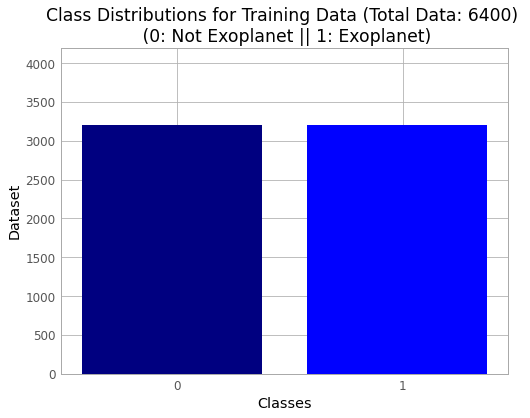

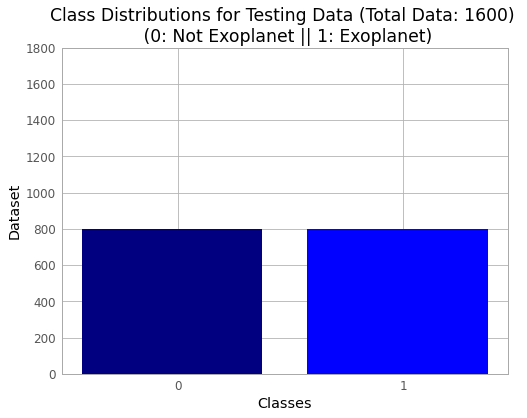

In [12]:
# Class Distrubution for training and testing data for Positive and Negative samples
Data_Distribution_train = {0:train_df_neg.shape[0], 1:train_df_pos.shape[0]}
Data_Distribution_test = {0:test_df_neg.shape[0], 1:test_df_pos.shape[0]}

x = [0,1]
width = 0.8
color = [0, 1]

# Distribtion of training data

fig, ax = plt.subplots(1, 1)
ax.set_ylim(0,train_df_neg.shape[0]+1000)
ax.set_ylabel('Dataset')
ax.set_xlabel('Classes')
ax.set_title('Class Distributions for Training Data (Total Data: {}) \n (0: Not Exoplanet || 1: Exoplanet)'.format(train_df_pos.shape[0]+train_df_neg.shape[0]))
ax.set_xticks(np.add(x,(width/32))) # set the position of the x ticks
ax.set_xticklabels(('0', '1'))
# Get a color map
my_cmap = cm.get_cmap('jet')
# Get normalize function (takes data in range [vmin, vmax] -> [0, 1])
my_norm = Normalize(vmin=0, vmax=8)
ax.bar(Data_Distribution_train.keys(), Data_Distribution_train.values(), color=my_cmap(my_norm(color)))
plt.show()

# Distribtion of testing data


fig, ax = plt.subplots(1, 1)
ax.set_ylim(0,test_df_neg.shape[0]+1000)
ax.set_ylabel('Dataset')
ax.set_xlabel('Classes')
ax.set_title('Class Distributions for Testing Data (Total Data: {}) \n (0: Not Exoplanet || 1: Exoplanet)'.format(test_df_pos.shape[0]+test_df_neg.shape[0]))
ax.set_xticks(np.add(x,(width/32))) # set the position of the x ticks
ax.set_xticklabels(('0', '1'))
# Get a color map
my_cmap = cm.get_cmap('jet')
# Get normalize function (takes data in range [vmin, vmax] -> [0, 1])
my_norm = Normalize(vmin=0, vmax=8)
ax.bar(Data_Distribution_test.keys(), Data_Distribution_test.values(), color=my_cmap(my_norm(color)))
plt.show()


The light  on which the analysis is to be done can be visualized as below. As seen from the below time series graph, first 3 graphs represent time series data for Positive data. That is, the celestial body is a Exo Planet. On the other hand, the last 3 graphs represent the time series for negative dataset. 

By observing both positive and negative data, the Exo planets time series is seen to have some specific pattern for flux intensity. On the contrary, the negative the shown random data also called as noise. There is no specific pattern. 

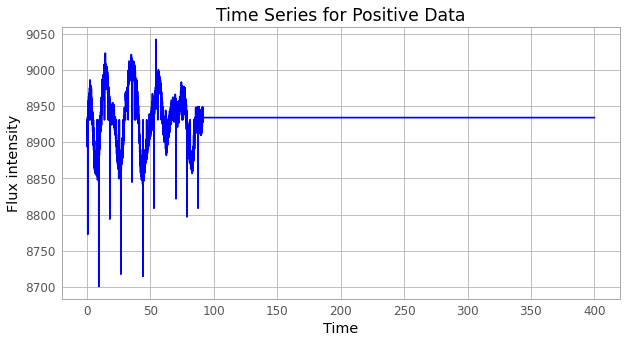

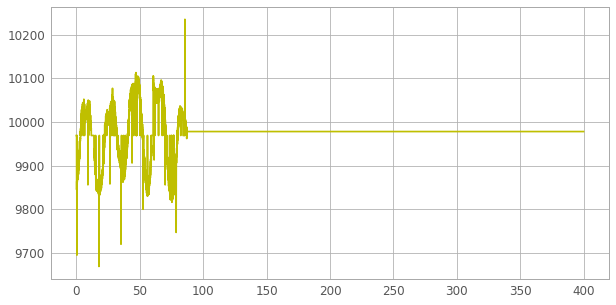

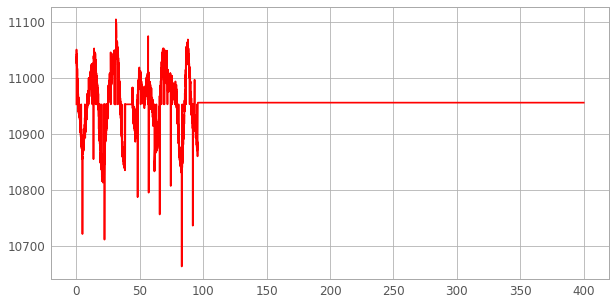

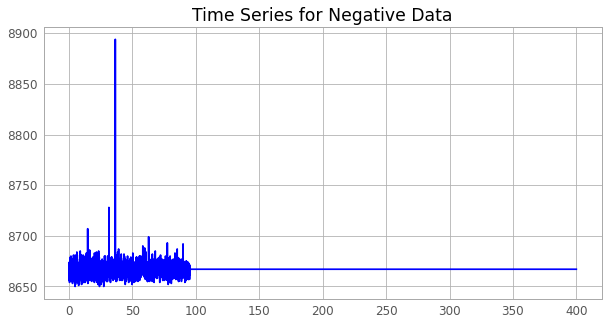

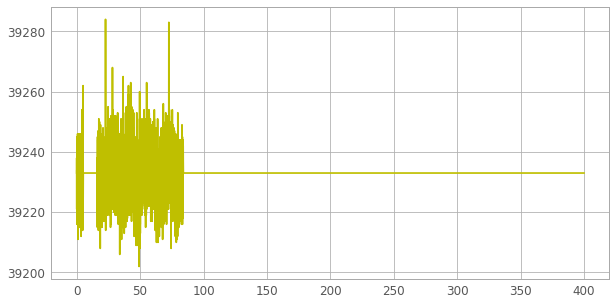

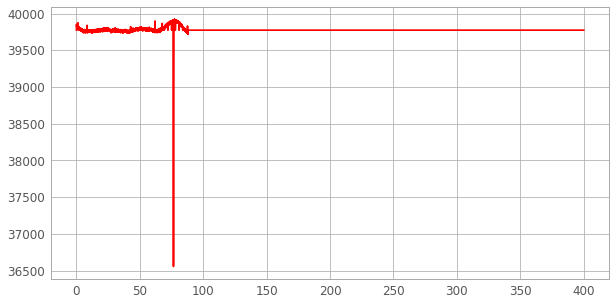

In [13]:
# Time series analysis 
# tt = np.linspace(0, 0.02*COLUMNS_FOR_TRAINING, num=COLUMNS_FOR_TRAINING)
# plt.plot(tt, X_train[45] )
tt = np.linspace(0, 0.02*COLUMNS_FOR_TRAINING, num=COLUMNS_FOR_TRAINING)
rcParams['figure.figsize'] = 10, 5
plt.title('Distribution of flux values', fontsize=10)
plt.xlabel('Time')
plt.ylabel('Flux intensity')
plt.title("Time Series for Positive Data")
plt.plot(tt, X_train[10], color="b")
plt.show()
plt.plot(tt, X_train[0], color="y")
plt.show()
plt.plot(tt, X_train[30], color="r")
plt.show()
plt.title("Time Series for Negative Data")
plt.plot(tt, X_train[-11], color="b")
plt.show()
plt.plot(tt, X_train[-21], color="y")
plt.show()
plt.plot(tt, X_train[-31], color="r")
plt.show()


<b>Recurrence plot</b> – A recurrence plot (RP) is an advanced technique of nonlinear data analysis. It is a visualisation (or a graph) of a square matrix, in which the matrix elements correspond to those times at which a state of a dynamical system recurs (columns and rows correspond then to a certain pair of times).

`Recurrence Plot` for above time series are shown below. As it can be seen that the Recurrence plots for positive data shows a certain pattern and the negative data shows a image with a lot of noise and random values. These plots can are used later for classification of exoplnets.    

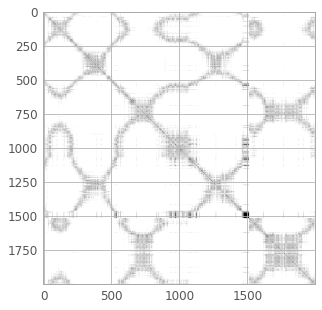

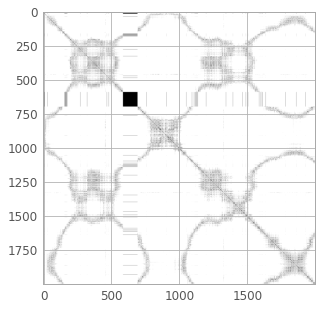

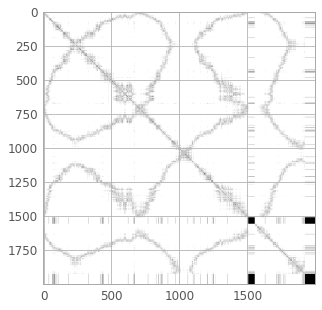

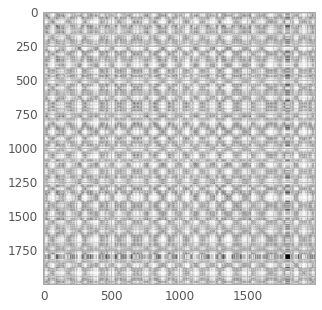

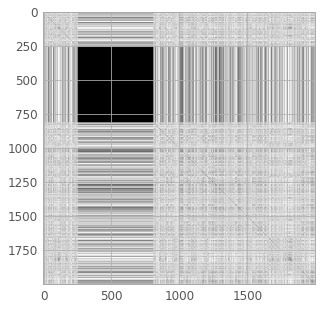

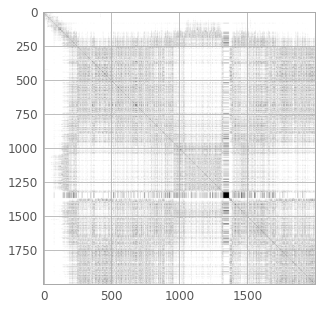

In [14]:
# Recurrence Plots from time curves
# 1, 2, 3 recurrence plots are for postive data and 4, 5, 6 are for negative data

def rec_plot(s, eps=0.50, steps=10):
    d = pdist(s[:,None])
    d = np.floor(d/eps)
    d[d>steps] = steps
    Z = squareform(d)
    return Z


List = [10,0,30]
for _, i in enumerate(List):
    image = rec_plot(X_train[i,:2000])
    plt.figure()
    plt.imshow(image,cmap="gray")
  
List = [X_train.shape[0]-11, X_train.shape[0]-21, X_train.shape[0]-31]
for _, i in enumerate(List):
    image = rec_plot(X_train[i,:2000])
    plt.figure()
    plt.imshow(image,cmap="gray")

Stacking recurrence plot images (Conversion from single channel to multi channel images) for VGG16 pre trained model.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape of image before resizing (3000, 3000)
Shape of image before resizing (100, 100)
Shape of image before resizing (3000, 3000)
Shape of image before resizing (100, 100)


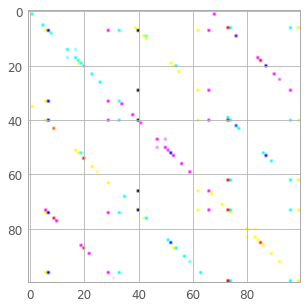

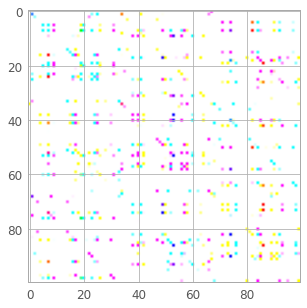

In [15]:
# 3 Channel image for Positive data
image_pos = rec_plot(X_train[0,:3000])
print("Shape of image before resizing",image_pos.shape)
image_pos = cv2.resize(image_pos, (HEIGHT,WIDTH), interpolation=cv2.INTER_CUBIC)
print("Shape of image before resizing",image_pos.shape)
image_pos = np.stack((image_pos, image_pos, image_pos),axis=0).reshape(HEIGHT,WIDTH,3)
plt.figure()
plt.imshow(image_pos)

# 3 Channel image for Negative data
image_neg = rec_plot(X_train[-11,:3000])
print("Shape of image before resizing",image_neg.shape)
image_neg = cv2.resize(image_neg, (HEIGHT,WIDTH), interpolation=cv2.INTER_CUBIC)
print("Shape of image before resizing",image_neg.shape)
image_neg = np.stack((image_neg, image_neg, image_neg),axis=0).reshape(HEIGHT,WIDTH,3)
plt.figure()
plt.imshow(image_neg)


Fast Fourier Transform(FFT) is applied on the time series data from the above cell. The results after application of FFT is shown below for positive and negative datasets. This application of FFT to the time series data is a preprocessing step which increases the accuracy of the model. These FFT transform values are later used for classification of Exoplanets.  

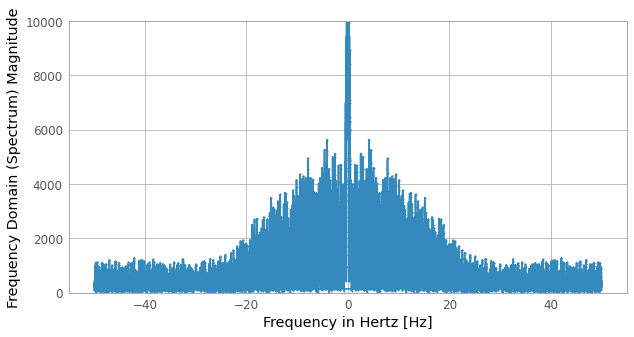

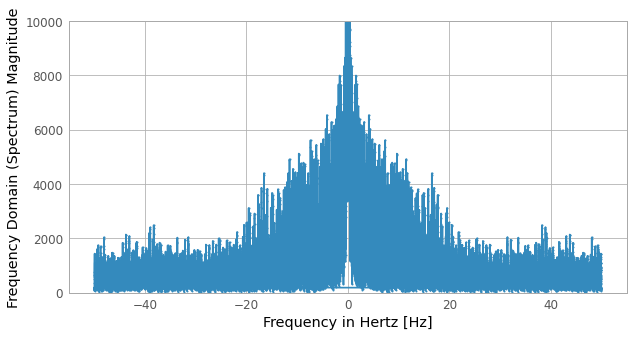

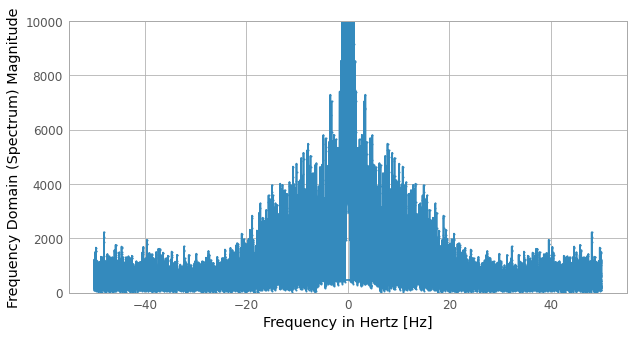

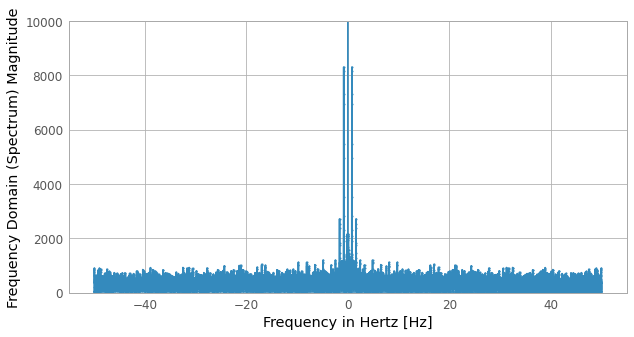

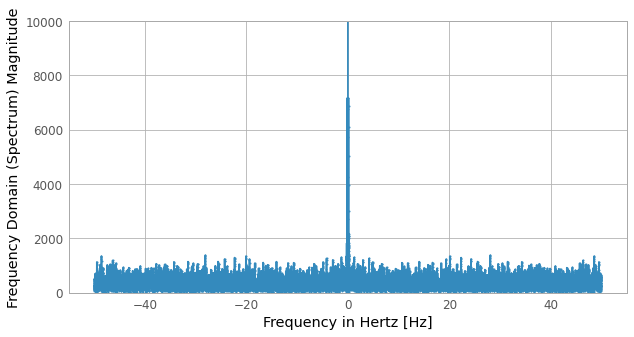

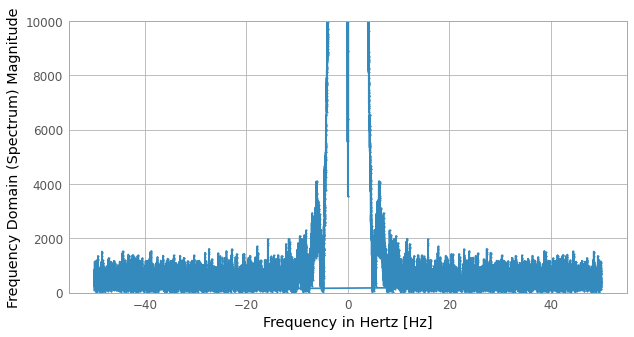

<Figure size 720x360 with 0 Axes>

In [16]:
# # FFT analysis
X_train_fft = np.abs(fft(X_train)).astype(np.float32)
X_test_fft = np.abs(fft(X_test)).astype(np.float32)


def Plot(X, i):
    f_s = 100
    freqs = fftpack.fftfreq(len(X_train_fft[i])) * f_s

    plt.xlabel('Frequency in Hertz [Hz]')
    plt.ylabel('Frequency Domain (Spectrum) Magnitude')
    # ax.set_xlim(-f_s / 2, f_s / 2)
    plt.ylim(0, 10000)
    plt.plot(freqs, X_train_fft[i], marker=".", markersize=2)
    plt.figure()  

Plot(X_train_fft[10],10)
Plot(X_train_fft[0],0)
Plot(X_train_fft[30],30)
Plot(X_train_fft[-11],-11)
Plot(X_train_fft[-21],-21)
Plot(X_train_fft[-31],-31)

### Time series Analysis

This section `Time series Analysis` consists of a Support Vector Model for classification of Exo-Planet. The data is the regular time series data. Results after calssification are compared with the FFT model to analyse the effect of FFT on classification accuracy.   

This module contains following cells:
- Shuffling the training and testing data
- Normalizing the data
- Creating the SVM model
- Prediction and Evaluation of results
- Accuracy, Classification report, Confusion Matrix, Receiver Operating Characteristic(ROC) Curve

In [21]:
Y_train_time = Y_train
Y_test_time = Y_test
X_train,Y_train_time = shuffle(X_train, Y_train_time, random_state=0)
X_test,Y_test_time = shuffle(X_test, Y_test_time, random_state=0)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)

In [22]:
X_train_time = np.array(X_train, copy=True) 
X_test_time = np.array(X_test, copy=True) 

for i in range(X_train.shape[0]):
    X_train_time[i] = X_train[i]/np.max(X_train[i])
for i in range(X_test.shape[0]):
    X_test_time[i] = X_test[i]/np.max(X_test[i])

In [23]:
data_dim = 1
timesteps = X_train.shape[1]
num_classes = 2

[-0.99989866 -1.00035896 -0.72466955 -0.99987716  0.13159601  0.13159601
  0.13159601  0.98786157 -0.72466955  0.13159601]

accuracy_score : 0.52125

classification report :
               precision    recall  f1-score   support

           0       0.53      0.34      0.42       800
           1       0.52      0.70      0.59       800

    accuracy                           0.52      1600
   macro avg       0.52      0.52      0.50      1600
weighted avg       0.52      0.52      0.50      1600



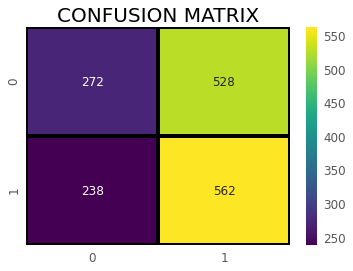

In [24]:
def model(classifier,dtrain_x,dtrain_y,dtest_x,dtest_y):
    #fit the model
    #classifier.probability=True
    classifier.fit(dtrain_x,dtrain_y)
    predictions = classifier.decision_function(dtest_x)
    predict_acc = classifier.predict(dtest_x)
    print(predictions[:10])
    #Accuracy
    print ("\naccuracy_score :",accuracy_score(dtest_y,predict_acc))
    
    #Classification report
    print ("\nclassification report :\n",(classification_report(dtest_y,predict_acc)))
    
    #Confusion matrix
    plt.figure(figsize=(13,10))
    plt.subplot(221)
    sns.heatmap(confusion_matrix(dtest_y,predict_acc),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
    plt.title("CONFUSION MATRIX",fontsize=20)
    return predictions

SVM_model=SVC()
predictions1 = model(SVM_model,
                    X_train_time.reshape(X_train_time.shape[0],X_train_time.shape[1]),
                    Y_train_time.reshape(Y_train_time.shape[0]),
                    X_test_time.reshape(X_test_time.shape[0],X_test_time.shape[1]),
                    Y_test_time.reshape(Y_test_time.shape[0]))

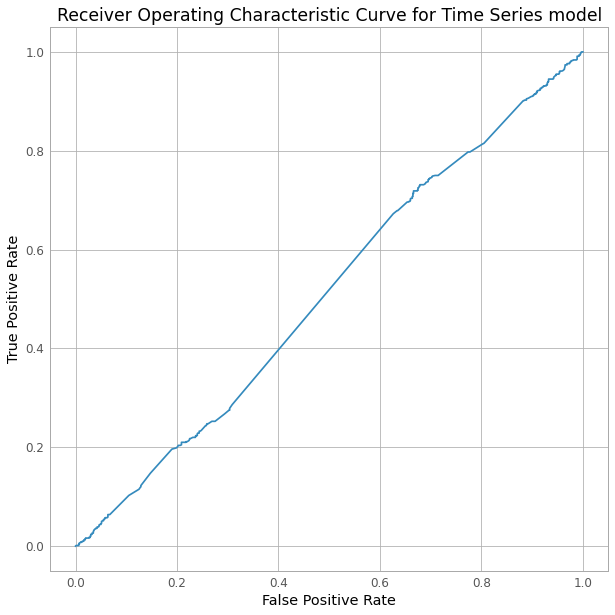

In [25]:
# Plotting ROC curves for all models 

false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(Y_test_time, predictions1)

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic Curve for Time Series model')
plt.plot(false_positive_rate1, true_positive_rate1)

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Recurrance plot Analysis

This section `Recurrency Plot Analysis` consists a Tranfer Learning VGG16 Model for classification of Exo-Planet. The data is Recurrence Plot images as shown above.   

This module contains following cells:
- Converting the times series data to Recurrence Plots. 
- Defining the VGG16 pretrained model + adding some custom top layers 
- Training the model
- Prediction and result Evaluation
- Accuracy, Classification report, Confusion Matrix, Receiver Operating Characteristic(ROC) Curve

In [17]:
x = []
for i in range(X_train.shape[0]):
    print(i)
    image = rec_plot(X_train[i,:3000].reshape(3000))
    image = cv2.resize(image, (HEIGHT,WIDTH), interpolation=cv2.INTER_CUBIC)
    image = np.stack((image, image, image),axis=0).reshape(HEIGHT,WIDTH,3)
    x.append(image)
X_TRAIN = np.array(x)
X_TRAIN.shape  
#X_TRAIN = X_TRAIN.reshape(X_TRAIN.shape[0], HEIGHT,WIDTH, 3, 1)

y = []
for i in range(X_test.shape[0]):
    print(i)
    image = rec_plot(X_test[i,:3000].reshape(3000))
    image = cv2.resize(image, (HEIGHT,WIDTH), interpolation=cv2.INTER_CUBIC)
    image = np.stack((image, image, image),axis=0).reshape(HEIGHT,WIDTH,3)
    y.append(image)
X_TEST = np.asarray(y) 
X_TEST.shape
#X_TEST = X_TEST.reshape(X_TEST.shape[0], HEIGHT, WIDTH, 3, 1)


Y_TRAIN = Y_train
Y_TEST = Y_test

Streaming output truncated to the last 5000 lines.
3000
3001
3002
3003
3004
3005
3006
3007
3008
3009
3010
3011
3012
3013
3014
3015
3016
3017
3018
3019
3020
3021
3022
3023
3024
3025
3026
3027
3028
3029
3030
3031
3032
3033
3034
3035
3036
3037
3038
3039
3040
3041
3042
3043
3044
3045
3046
3047
3048
3049
3050
3051
3052
3053
3054
3055
3056
3057
3058
3059
3060
3061
3062
3063
3064
3065
3066
3067
3068
3069
3070
3071
3072
3073
3074
3075
3076
3077
3078
3079
3080
3081
3082
3083
3084
3085
3086
3087
3088
3089
3090
3091
3092
3093
3094
3095
3096
3097
3098
3099
3100
3101
3102
3103
3104
3105
3106
3107
3108
3109
3110
3111
3112
3113
3114
3115
3116
3117
3118
3119
3120
3121
3122
3123
3124
3125
3126
3127
3128
3129
3130
3131
3132
3133
3134
3135
3136
3137
3138
3139
3140
3141
3142
3143
3144
3145
3146
3147
3148
3149
3150
3151
3152
3153
3154
3155
3156
3157
3158
3159
3160
3161
3162
3163
3164
3165
3166
3167
3168
3169
3170
3171
3172
3173
3174
3175
3176
3177
3178
3179
3180
3181
3182
3183
3184
3185
3186
3187
3188
3189

In [18]:
X_train[i,:3000].shape

(3000,)

In [19]:
X_TRAIN,Y_TRAIN = shuffle(X_TRAIN, Y_TRAIN, random_state=0)
X_TEST,Y_TEST = shuffle(X_TEST, Y_TEST, random_state=0)

In [20]:
# Transforming labels to correct format
train_labels = to_categorical(Y_TRAIN, num_classes=2)
test_labels = to_categorical(Y_TEST, num_classes=2)
# train_labels = Y_TRAIN
# test_labels = Y_TEST

In [21]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=X_TRAIN[0].shape)

base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(X_TRAIN) 
test_ds = preprocess_input(X_TEST)

58900480/58889256 [==============================] - 1s 0us/step


In [22]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(HEIGHT, WIDTH, 3))
base_model.trainable = False ## Not trainable weights

## Preprocessing input
# train_ds = preprocess_input(X_TRAIN.reshape(X_TRAIN.shape[0],HEIGHT,WIDTH,3)) 
# test_ds = preprocess_input(X_TEST.reshape(X_TEST.shape[0],HEIGHT,WIDTH,3))

In [23]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [24]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(256, activation='relu')
dense_layer_2 = layers.Dense(180, activation='relu')
dense_layer_3 = layers.Dense(128, activation='relu')
dense_layer_4 = layers.Dense(64, activation='relu')
prediction_layer = layers.Dense(2, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    #dense_layer_1,
    #dense_layer_2,
    dense_layer_3,
    dense_layer_4,
    prediction_layer
])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               589952    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
Total params: 15,313,026
Trainable params: 598,338
Non-trainable params: 14,714,688
_________________________________________________________________


In [26]:
model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

history2 = model.fit(train_ds, train_labels, epochs=50, validation_split=0.2, batch_size=32, callbacks=[es])


Epoch 1/50
160/160 [==============================] - 45s 93ms/step - loss: 0.7780 - accuracy: 0.5311 - val_loss: 0.6859 - val_accuracy: 0.5641
Epoch 2/50
160/160 [==============================] - 14s 85ms/step - loss: 0.7026 - accuracy: 0.5514 - val_loss: 0.6716 - val_accuracy: 0.5703
Epoch 3/50
160/160 [==============================] - 14s 85ms/step - loss: 0.6807 - accuracy: 0.5658 - val_loss: 0.6749 - val_accuracy: 0.5680
Epoch 4/50
160/160 [==============================] - 14s 85ms/step - loss: 0.6696 - accuracy: 0.5969 - val_loss: 0.6764 - val_accuracy: 0.5594
Epoch 5/50
160/160 [==============================] - 14s 86ms/step - loss: 0.6692 - accuracy: 0.5861 - val_loss: 0.6719 - val_accuracy: 0.5695
Epoch 6/50
160/160 [==============================] - 16s 102ms/step - loss: 0.6618 - accuracy: 0.5984 - val_loss: 0.6832 - val_accuracy: 0.5625
Epoch 7/50
160/160 [==============================] - 14s 87ms/step - loss: 0.6570 - accuracy: 0.6029 - val_loss: 0.6805 - val_accuracy

In [27]:
prediction3 = model.predict(test_ds) 


accuracy_score : 0.56625

classification report :
               precision    recall  f1-score   support

           0       0.55      0.78      0.64       800
           1       0.62      0.35      0.45       800

    accuracy                           0.57      1600
   macro avg       0.58      0.57      0.54      1600
weighted avg       0.58      0.57      0.54      1600



Text(0.5, 1.0, 'CONFUSION MATRIX')

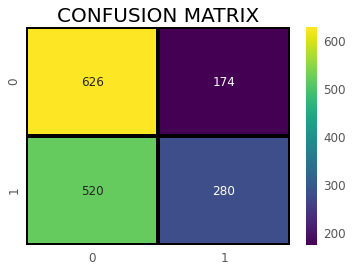

In [28]:
predict=[]
for i in range(prediction3.shape[0]):
    if (prediction3[i][0] >= prediction3[i][1]):
        predict.append(0)   
    else:
        predict.append(1) 
    
output = np.array(predict)
output = output.reshape(output.shape[0],1)

print ("\naccuracy_score :",accuracy_score(Y_TEST,output))
    
#Classification report
print ("\nclassification report :\n",(classification_report(Y_TEST,output)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(Y_TEST,output),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

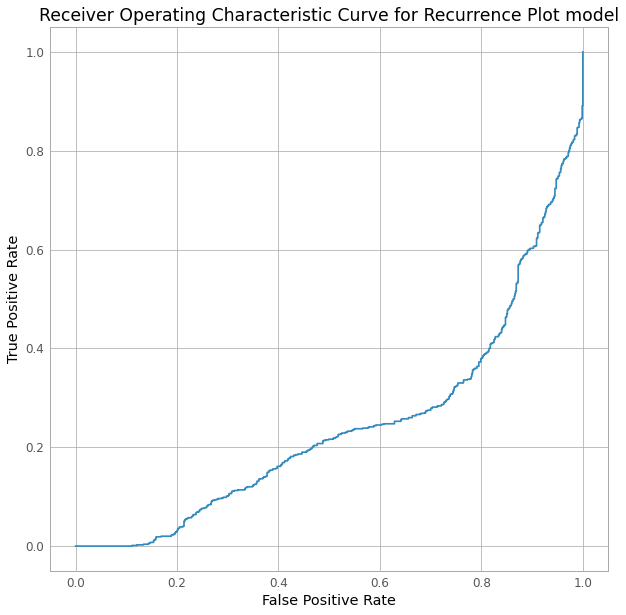

In [29]:
# Plotting ROC curves for all models 

prob=[]
for i in range(prediction3.shape[0]):
    if Y_TEST[i]==0:
        prob.append(prediction3[i][0])
    else:
        prob.append(prediction3[i][1])
prob_array = np.array(prob)
prob_array = prob_array.reshape(prob_array.shape[0],1)  

false_positive_rate2, true_positive_rate2, threshold1 = roc_curve(Y_TEST,prob_array)

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic Curve for Recurrence Plot model')

plt.plot(false_positive_rate2, true_positive_rate2)

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### FFT Analysis

This section `FFT Analysis` consists of a Support Vector Model for classification of Exo-Planet. The data consists of time series data converted to Frequency domain after applying Fast Fourier Transform. Results after calssification are compared with the Time Series model to analyse the effect of FFT on classification accuracy.   

This module contains following cells:
- Shuffling the training and testing data
- Normalizing the data
- Creating the SVM model
- Prediction and Evaluation of results
- Accuracy, Classification report, Confusion Matrix, Receiver Operating Characteristic(ROC) Curve

In [17]:
for i in range(X_train_fft.shape[0]):
    X_train_fft[i] = X_train_fft[i]/np.max(X_train_fft[i])
for i in range(X_test_fft.shape[0]):
    X_test_fft[i] = X_test_fft[i]/np.max(X_test_fft[i])

In [18]:
X_train_fft = X_train_fft[:,1:]
X_test_fft = X_test_fft[:,1:]

X_train_fft[0][:10]

array([1.75606372e-04, 1.09920278e-04, 8.19204361e-05, 1.64650352e-04,
       2.52999685e-04, 3.07076523e-04, 3.15400714e-04, 2.78724008e-04,
       2.04702577e-04, 1.04278035e-04], dtype=float32)

In [19]:
Y_train_fft = Y_train
Y_test_fft = Y_test
X_train_fft,Y_train_fft = shuffle(X_train_fft, Y_train_fft, random_state=0)
X_test_fft,Y_test_fft = shuffle(X_test_fft, Y_test_fft, random_state=0)
X_test_fft = X_test_fft.reshape(X_test_fft.shape[0],X_test_fft.shape[1],1)
X_train_fft = X_train_fft.reshape(X_train_fft.shape[0],X_train_fft.shape[1],1)

# X_train_fft = X_train_fft[1:]
# X_test_fft = X_test_fft[1:] 
# Y_train = Y_train[1:]
# Y_test = Y_test[1:]


accuracy_score : 0.586875

classification report :
               precision    recall  f1-score   support

           0       0.55      0.98      0.70       800
           1       0.89      0.20      0.32       800

    accuracy                           0.59      1600
   macro avg       0.72      0.59      0.51      1600
weighted avg       0.72      0.59      0.51      1600



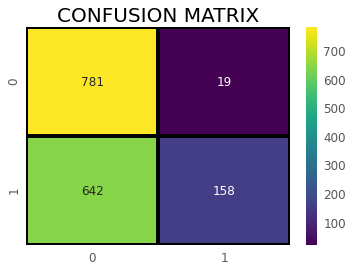

In [20]:
def model(classifier,dtrain_x,dtrain_y,dtest_x,dtest_y):
    #fit the model
    classifier.fit(dtrain_x,dtrain_y)
    predictions = classifier.decision_function(dtest_x)
    predict_acc = classifier.predict(dtest_x)
    
    #Accuracy
    print ("\naccuracy_score :",accuracy_score(dtest_y,predict_acc))
    
    #Classification report
    print ("\nclassification report :\n",(classification_report(dtest_y,predict_acc)))
    
    #Confusion matrix
    plt.figure(figsize=(13,10))
    plt.subplot(221)
    sns.heatmap(confusion_matrix(dtest_y,predict_acc),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
    plt.title("CONFUSION MATRIX",fontsize=20)
    return predictions

SVM_model=SVC()
predictions3 = model(SVM_model,
                              X_train_fft.reshape(X_train_fft.shape[0],X_train_fft.shape[1]),
                              Y_train_fft.reshape(Y_train_fft.shape[0]),
                              X_test_fft.reshape(X_test_fft.shape[0],X_test_fft.shape[1]),
                              Y_test_fft.reshape(Y_test_fft.shape[0]))

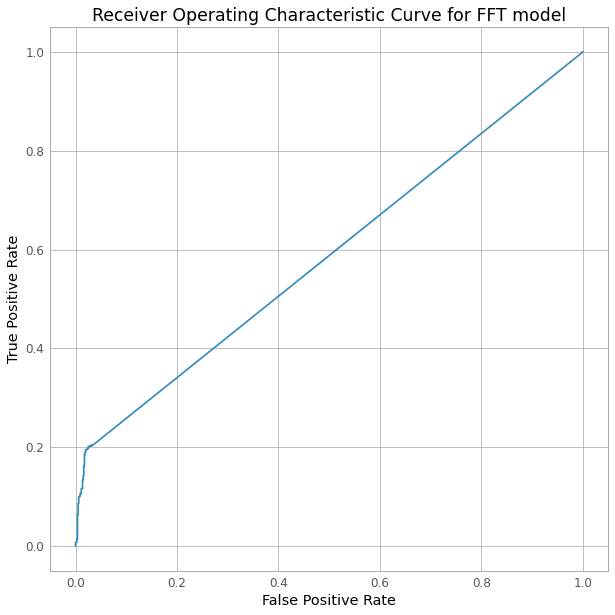

In [23]:
# Plotting ROC curves for all models 

false_positive_rate3, true_positive_rate3, threshold3 = roc_curve(Y_test_fft, predictions3)

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic Curve for FFT model')
plt.plot(false_positive_rate3, true_positive_rate3)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



`Note:`

The data used for the three models above is a part of acutal data. Due to hardware limitations it was not possible to use all the available data. Therefore, the accuracy is low. The accuracy can be improved by considering more training data. 